In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

sys.path.append(os.path.abspath(".."))

import config


--- TFRecords Creation Check ---
Checking directory: ../processed_data
Files found: ['dataset.tfrecords', 'real_images.tfrecord', 'fake_images.tfrecord']
TFRecord files: ['real_images.tfrecord', 'fake_images.tfrecord']
real_images.tfrecord: 1201110000 bytes
fake_images.tfrecord: 1201110000 bytes
TFRecord File Paths:
Fake Images: ../processed_data/fake_images.tfrecord
Real Images: ../processed_data/real_images.tfrecord

Dataset Counts:


2025-03-25 14:23:33.848838: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Fake Images: 10000


2025-03-25 14:23:34.615092: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Real Images: 10000


2025-03-25 14:23:36.507888: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


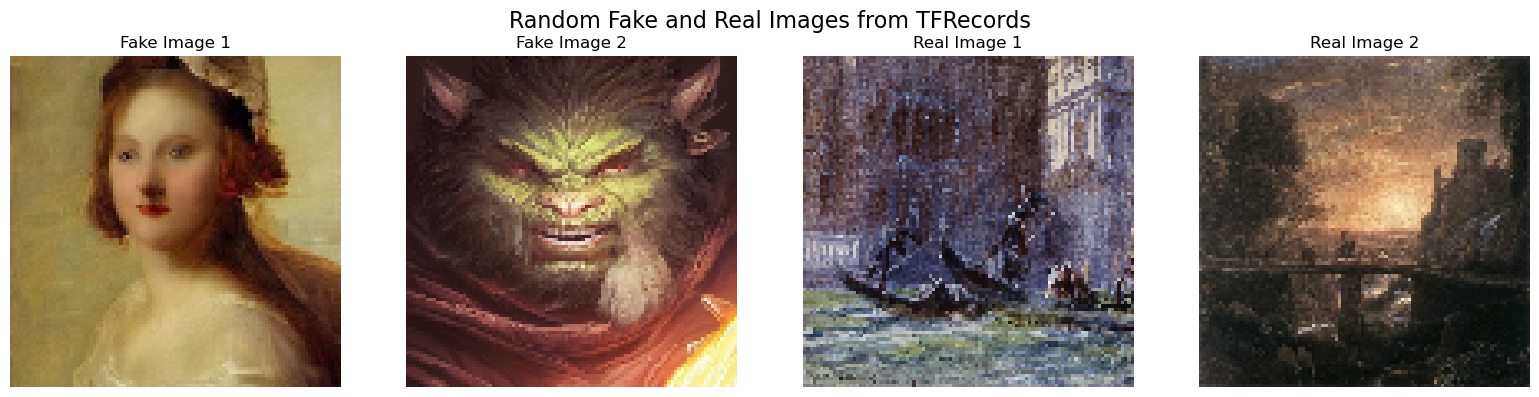

In [ ]:
class TFRecordsViewer:
    def __init__(self, tfrecords_dir):
        """
        Initialize TFRecords viewer
        
        Args:
            tfrecords_dir (str): Directory containing TFRecord files
        """
        self.tfrecords_dir = tfrecords_dir
        self.fake_tfrecord = os.path.join(
            tfrecords_dir, 'fake_images.tfrecord')
        self.real_tfrecord = os.path.join(
            tfrecords_dir, 'real_images.tfrecord')

    def _parse_tfrecord(self, example_proto):
        """
        Parse TFRecord and extract features with more robust error handling
        
        Args:
            example_proto (tf.Tensor): Serialized TFRecord example
        
        Returns:
            Tuple of (image, label)
        """
        try:
            IMAGE_SIZE = config.IMG_SIZE
            feature_description = {
                'image': tf.io.FixedLenFeature(IMAGE_SIZE[0]*IMAGE_SIZE[1]*3, tf.float32),
                'label': tf.io.FixedLenFeature([], tf.int64),
                'height': tf.io.FixedLenFeature([], tf.int64),
                'width': tf.io.FixedLenFeature([], tf.int64),
                'channels': tf.io.FixedLenFeature([], tf.int64)
            }

            parsed_features = tf.io.parse_single_example(
                example_proto, feature_description)

            image = tf.reshape(parsed_features['image'],
                               [parsed_features['height'],
                                parsed_features['width'],
                                parsed_features['channels']])

            image = tf.clip_by_value(image, 0.0, 1.0)

            label = parsed_features['label']

            return image, label

        except Exception as e:
            print(f"Error parsing TFRecord: {e}")
            return None, None

    def load_dataset(self, tfrecord_path):
        """
        Load dataset from TFRecord file with error checking
        
        Args:
            tfrecord_path (str): Path to TFRecord file
        
        Returns:
            tf.data.Dataset
        """
        if not os.path.exists(tfrecord_path):
            print(f"Error: TFRecord file not found at {tfrecord_path}")
            print(f"Contents of {os.path.dirname(tfrecord_path)}:")
            print(os.listdir(os.path.dirname(tfrecord_path)))
            return None

        try:
            dataset = tf.data.TFRecordDataset(tfrecord_path)
            dataset = dataset.map(self._parse_tfrecord)
            dataset = dataset.filter(lambda x, y: x is not None)
            return dataset
        except Exception as e:
            print(f"Error loading TFRecord dataset: {e}")
            return None

    def visualize_random_images(self, num_images=2):
        """
        Visualize random images from fake and real datasets
        
        Args:
            num_images (int): Number of images to display per category
        """
        fake_dataset = self.load_dataset(self.fake_tfrecord)
        real_dataset = self.load_dataset(self.real_tfrecord)

        if fake_dataset is None or real_dataset is None:
            print("Cannot proceed with visualization due to dataset loading errors.")
            return

        try:
            fake_images = list(fake_dataset.as_numpy_iterator())
            real_images = list(real_dataset.as_numpy_iterator())
        except Exception as e:
            print(f"Error converting dataset to list: {e}")
            return

        if not fake_images or not real_images:
            print("No images found in the datasets.")
            return

        plt.figure(figsize=(16, 4))
        plt.suptitle('Random Fake and Real Images from TFRecords', fontsize=16)

        def get_random_image(images):
            try:
                return images[np.random.randint(len(images))][0]
            except Exception as e:
                print(f"Error selecting random image: {e}")
                return None

        image_positions = [1, 2, 3, 4]
        titles = ['Fake Image 1', 'Fake Image 2',
                  'Real Image 1', 'Real Image 2']
        image_sources = [fake_images, fake_images, real_images, real_images]

        for pos, title, source in zip(image_positions, titles, image_sources):
            plt.subplot(1, 4, pos)
            plt.title(title)

            img = get_random_image(source)
            if img is not None:
                plt.imshow(img)
                plt.axis('off')
            else:
                plt.text(0.5, 0.5, 'Image Not Found',
                         horizontalalignment='center',
                         verticalalignment='center')

        plt.tight_layout()
        plt.show()

    def print_dataset_info(self):
        """
        Print detailed information about the datasets
        """
        def count_dataset(dataset):
            """Count items in a dataset"""
            if dataset is None:
                return 0
            return sum(1 for _ in dataset)

        fake_dataset = self.load_dataset(self.fake_tfrecord)
        real_dataset = self.load_dataset(self.real_tfrecord)

        print("TFRecord File Paths:")
        print(f"Fake Images: {self.fake_tfrecord}")
        print(f"Real Images: {self.real_tfrecord}")

        print("\nDataset Counts:")
        print(f"Total Fake Images: {count_dataset(fake_dataset)}")
        print(f"Total Real Images: {count_dataset(real_dataset)}")



viewer = TFRecordsViewer(config.OUTPUT_TFRECORD_DIR)
viewer.print_dataset_info()

# random images
viewer.visualize_random_images()